In [117]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:

tf.config.optimizer.set_jit(True) 
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [ ]:

dataset_dir = 'flowers'
classes = sorted(os.listdir(dataset_dir))
print("Flower classes:", classes)


Flower classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(160, 160),  
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3)
)

for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]


In [ ]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks
)


Epoch 1/20
55/55 [==============================] - 343s 6s/step - loss: 1.0708 - accuracy: 0.6257 - val_loss: 0.6182 - val_accuracy: 0.8221 - lr: 5.0000e-05
Epoch 2/20
55/55 [==============================] - 330s 6s/step - loss: 0.5288 - accuracy: 0.8152 - val_loss: 0.4520 - val_accuracy: 0.8558 - lr: 5.0000e-05
Epoch 3/20
55/55 [==============================] - 329s 6s/step - loss: 0.4385 - accuracy: 0.8409 - val_loss: 0.3837 - val_accuracy: 0.8698 - lr: 5.0000e-05
Epoch 4/20
55/55 [==============================] - 333s 6s/step - loss: 0.3694 - accuracy: 0.8626 - val_loss: 0.3982 - val_accuracy: 0.8640 - lr: 5.0000e-05
Epoch 5/20
55/55 [==============================] - 330s 6s/step - loss: 0.3096 - accuracy: 0.8921 - val_loss: 0.3190 - val_accuracy: 0.8849 - lr: 5.0000e-05
Epoch 6/20
55/55 [==============================] - 328s 6s/step - loss: 0.2697 - accuracy: 0.9016 - val_loss: 0.3389 - val_accuracy: 0.8767 - lr: 5.0000e-05
Epoch 7/20
55/55 [==============================] - 

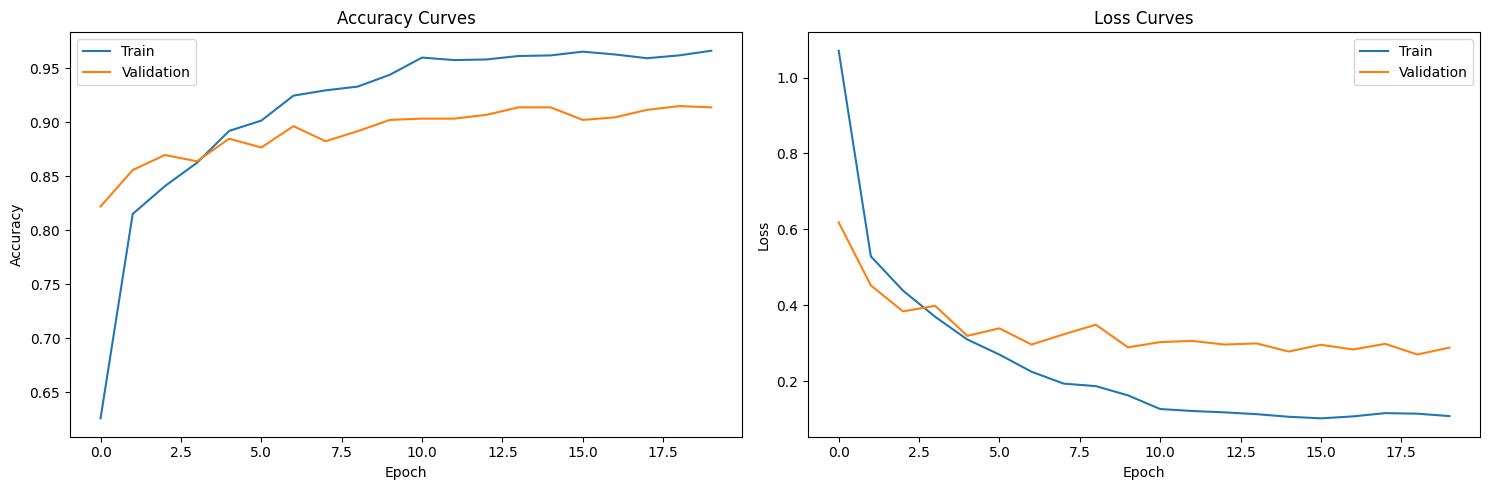

2/2 [==============================] - 6s 3s/step


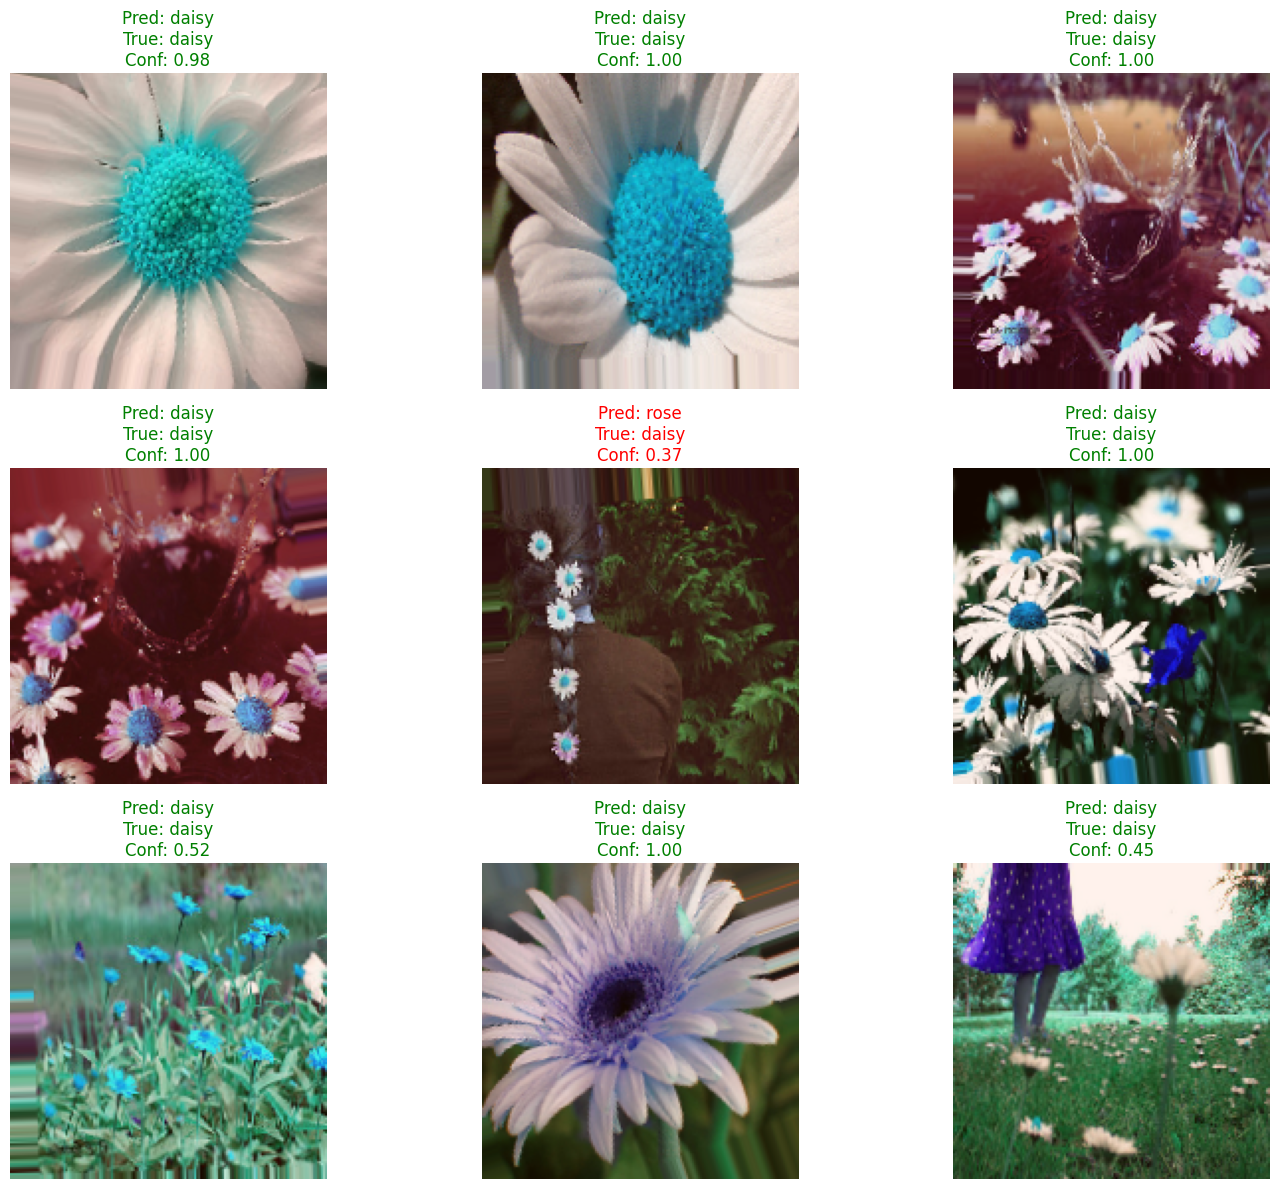

In [ ]:

def plot_enhanced_results():
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    test_images, test_labels = next(val_generator)
    preds = model.predict(test_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = test_images[i].copy()
        img = (img - img.min()) / (img.max() - img.min())
        
        pred_class = classes[np.argmax(preds[i])]
        true_class = classes[np.argmax(test_labels[i])]
        confidence = np.max(preds[i])
        
        color = 'green' if pred_class == true_class else 'red'
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.2f}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_enhanced_results()